**Implementación v16**

In [27]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# =========================================
# Generadores pseudoaleatorios y Aleatorios
# =========================================
def multiplicador_constante(semilla, a, d, n):
    numeros = []
    x = semilla
    for _ in range(n):
        producto = x * a
        producto_str = str(producto).zfill(2 * d)
        inicio = (len(producto_str) - d) // 2
        fin = inicio + d
        x = int(producto_str[inicio:fin])
        numeros.append(x)
    return numeros

def generar_uniformes(semilla, a, d, n):
    numeros = multiplicador_constante(semilla, a, d, n)
    max_val = 10**d
    return [x / max_val for x in numeros]

def generar_exponencial(uniformes, lambd):
    return [-(1/lambd) * math.log(u) for u in uniformes if u > 0]

def generar_normal(uniformes, mu, sigma):
    normales = []
    for i in range(0, len(uniformes)-1, 2):
        u1, u2 = uniformes[i], uniformes[i+1]
        z1 = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
        z2 = math.sqrt(-2 * math.log(u1)) * math.sin(2 * math.pi * u2)
        normales.append(mu + sigma * z1)
        normales.append(mu + sigma * z2)
    return normales

def generar_poisson(uniformes, lambd):
    resultados = []
    for u in uniformes:
        L = math.exp(-lambd)
        k, p = 0, 1
        while p > L:
            k += 1
            p *= u if u > 0 else 1e-6
        resultados.append(k - 1)
    return resultados

In [28]:
# ============================
# Simulación
# ============================
def simular_centro_servicio(num_vehiculos=30, num_estaciones=2, num_operarios=2):
    semilla = 7531
    a = 3797
    d = 4
    n = num_vehiculos * 3  # Generamos el número de uniformes

    uniformes = generar_uniformes(semilla, a, d, n)

    # Llegadas (exponencial λ=0.2)
    llegadas = generar_exponencial(uniformes, lambd=1/30)  # Promedio de 30 mins entre llegadas

    # Servicios (normal μ=6, σ=2)
    servicios = generar_normal(uniformes, mu=30, sigma=7)

    llegada_acum = 0
    datos = []

    estaciones_libres = [0] * num_estaciones
    operarios_libres = [0] * num_operarios

    for i in range(num_vehiculos):
        llegada_acum += llegadas[i]
        servicio = max(15, round(servicios[i],2))  # Servicio mínimo de 15 minutos

        estacion_idx = estaciones_libres.index(min(estaciones_libres))
        operario_idx = operarios_libres.index(min(operarios_libres))

        inicio = max(llegada_acum, estaciones_libres[estacion_idx], operarios_libres[operario_idx])
        fin = inicio + servicio
        espera = inicio - llegada_acum

        estaciones_libres[estacion_idx] = fin
        operarios_libres[operario_idx] = fin

        datos.append({
            "Vehiculo": i+1,
            "Llegada": llegada_acum,
            "Inicio_Atencion": inicio,
            "Fin_Atencion": fin,
            "Tiempo_Servicio": servicio,
            "Espera": espera,
            "Estacion": estacion_idx+1,
            "Operario": operario_idx+1
        })

    return pd.DataFrame(datos), llegadas, servicios

In [32]:
# ============================
# Menú interactivo
# ============================
def menu_simulacion():
    print("\n--- Simulación Centro de Servicio ---")
    print("Presiona Enter para usar el valor por defecto\n")

    try:
        num_vehiculos = input("Número de vehículos (default=30): ")
        num_estaciones = input("Número de estaciones (default=2): ")
        num_operarios = input("Número de operarios (default=2): ")

        # Si el usuario deja vacío, se toma el default
        num_vehiculos = int(num_vehiculos) if num_vehiculos.strip() else 30
        num_estaciones = int(num_estaciones) if num_estaciones.strip() else 2
        num_operarios = int(num_operarios) if num_operarios.strip() else 2

        df, llegadas, servicios = simular_centro_servicio(
            num_vehiculos=num_vehiculos,
            num_estaciones=num_estaciones,
            num_operarios=num_operarios
        )
        print("\n--- Resultados de la Simulación ---\n")
        print("Primeros 5 registros del DataFrame:")
        print(df.head())  # Mostrar las primeras filas del DataFrame

        # Resultados adicionales
        num_atendidos = len(df)
        num_espera = (df["Espera"] > 0).sum()
        espera_promedio = df["Espera"].mean()
        tiempo_total = df["Fin_Atencion"].max()
        uso_estaciones = df.groupby("Estacion")["Tiempo_Servicio"].sum() / tiempo_total
        uso_operarios = df.groupby("Operario")["Tiempo_Servicio"].sum() / tiempo_total

        print("\n=== Resumen de la Simulación ===")
        print(f"Vehículos atendidos: {num_atendidos}")
        
        print(f"Vehículos con espera: {num_espera}")
        
        print(f"Promedio de espera: {espera_promedio:.2f} mins")
        
        print("\nUtilización de estaciones:")
        print(uso_estaciones)
        
        print("\nUtilización de operarios:")
        print(uso_operarios)

        return df, llegadas, servicios

    except ValueError:
        print("Entrada inválida. Usa solo números o Enter.")
        return None

In [30]:
# ============================
# Función de graficado
# ============================
def graficar_numeros(numeros, titulo):
    plt.figure(figsize=(12, 5))

    # Dispersión
    plt.subplot(1, 2, 1)
    plt.scatter(range(len(numeros)), numeros, s=10, color='blue')
    plt.title(f"Dispersión - {titulo}")
    plt.xlabel("Índice")
    plt.ylabel("Valor")

    # Histograma
    plt.subplot(1, 2, 2)
    plt.hist(numeros, bins=10, color='orange', edgecolor='black')
    plt.title(f"Histograma - {titulo}")
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia")

    plt.tight_layout()
    plt.show()


--- Simulación Centro de Servicio ---
Presiona Enter para usar el valor por defecto


--- Resultados de la Simulación ---

Primeros 5 registros del DataFrame:
   Vehiculo    Llegada  Inicio_Atencion  Fin_Atencion  Tiempo_Servicio  \
0         1  15.565734        15.565734     39.785734            24.22   
1         2  30.905506        30.905506     56.725506            25.82   
2         3  38.723082        39.785734     69.485734            29.70   
3         4  79.181481        79.181481    114.221481            35.04   
4         5  83.811001        83.811001    110.041001            26.23   

     Espera  Estacion  Operario  
0  0.000000         1         1  
1  0.000000         2         2  
2  1.062652         1         1  
3  0.000000         2         2  
4  0.000000         1         1  

=== Resumen de la Simulación ===
Vehículos atendidos: 30
Vehículos con espera: 7
Promedio de espera: 2.65 mins

Utilización de estaciones:
Estacion
1    0.577675
2    0.469924
Name: Tiempo_S

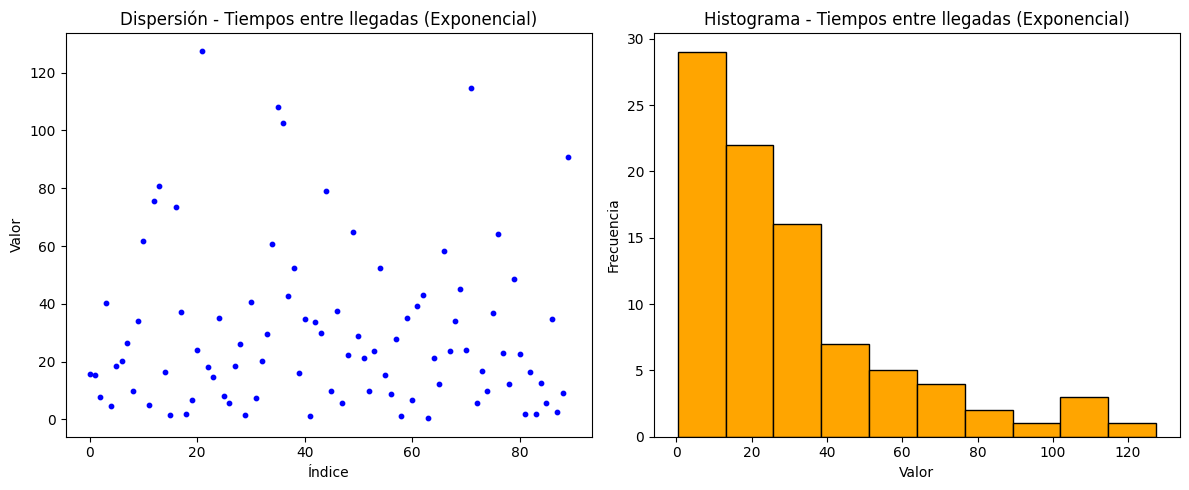

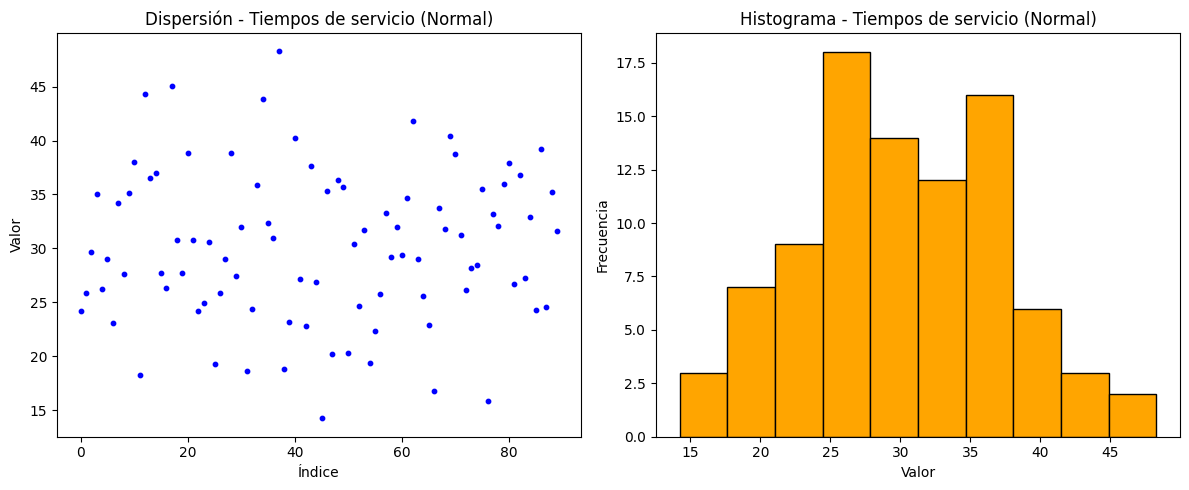

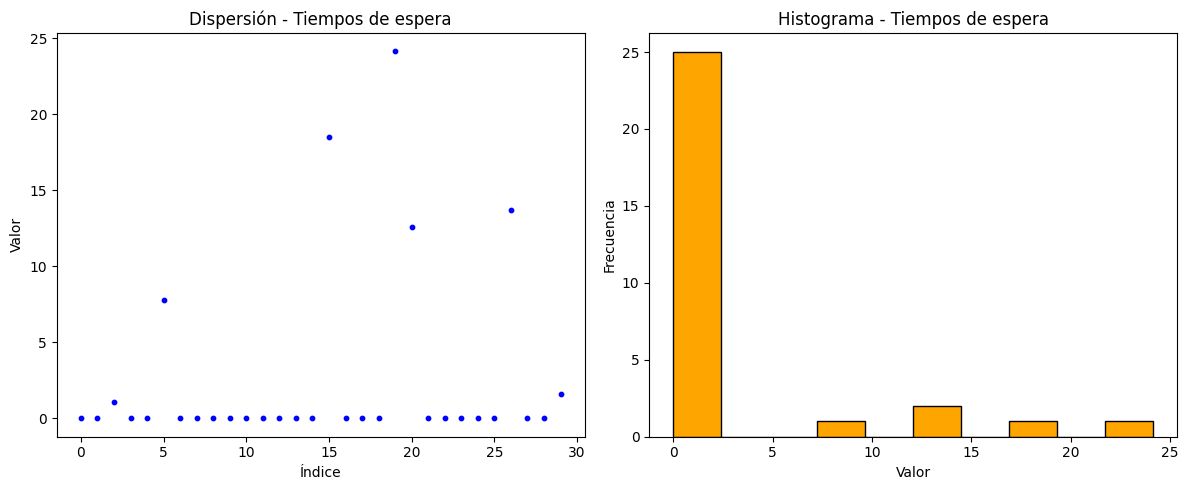

<Figure size 1000x500 with 0 Axes>

<Axes: xlabel='Estacion'>

Text(0.5, 1.0, 'Utilización de Estaciones')

Text(0, 0.5, 'Proporción de uso')

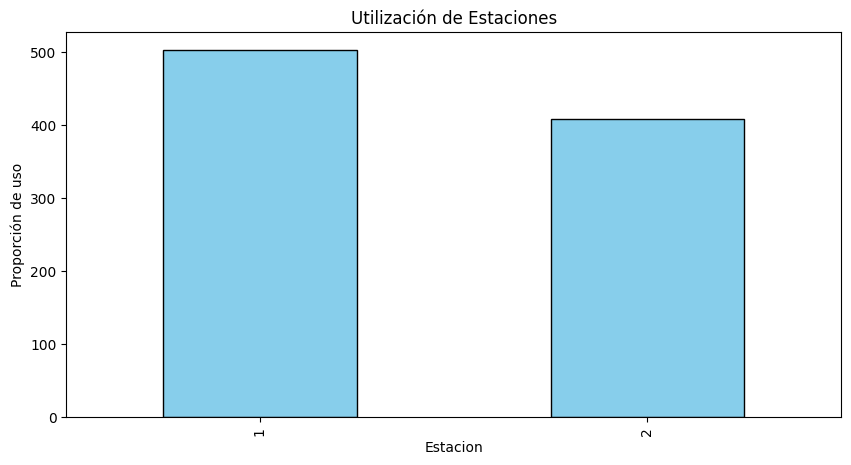

<Figure size 1000x500 with 0 Axes>

<Axes: xlabel='Operario'>

Text(0.5, 1.0, 'Utilización de Operarios')

Text(0, 0.5, 'Proporción de uso')

<function matplotlib.pyplot.show(close=None, block=None)>

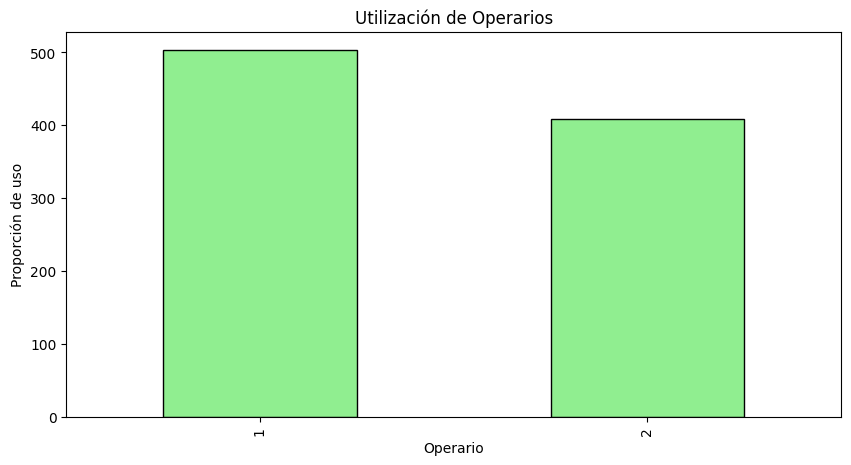

In [33]:
# ============================
# Ejecutar simulación
# ============================
if __name__ == "__main__":
    df, llegadas, servicios = menu_simulacion()

    if df is not None:
        # Graficar resultados
        graficar_numeros(llegadas, "Tiempos entre llegadas (Exponencial)")
        graficar_numeros(servicios, "Tiempos de servicio (Normal)")
        graficar_numeros(df["Espera"], "Tiempos de espera")

        # Barras de utilización
        plt.figure(figsize=(10,5))
        df.groupby("Estacion")["Tiempo_Servicio"].sum().plot(kind="bar", color="skyblue", edgecolor="black")
        plt.title("Utilización de Estaciones")
        plt.ylabel("Proporción de uso")
        plt.show()

        plt.figure(figsize=(10,5))
        df.groupby("Operario")["Tiempo_Servicio"].sum().plot(kind="bar", color="lightgreen", edgecolor="black")
        plt.title("Utilización de Operarios")
        plt.ylabel("Proporción de uso")
        plt.show